In [1]:
import os


os.chdir("C:/eCommerce_Project")  # folder 
print(os.getcwd())  # Checking the working directory

C:\eCommerce_Project


In [6]:
# Loading the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Checking the first few rows of each dataset to understand their structure
print(customers.head())
print(products.head())
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067   2024-04-25 7:38:55         1   
3       

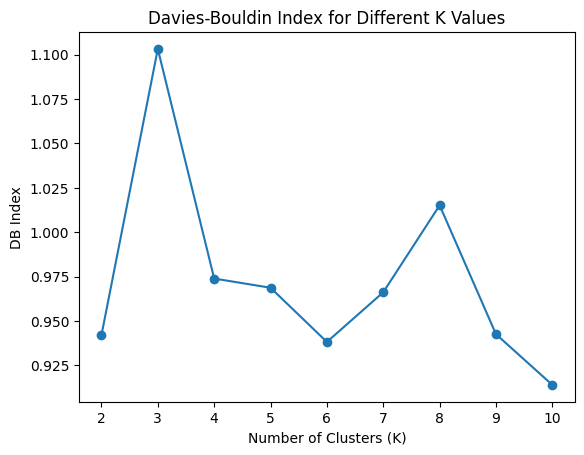

Optimal number of clusters: 10
Davies-Bouldin Index: 0.9139745364618437


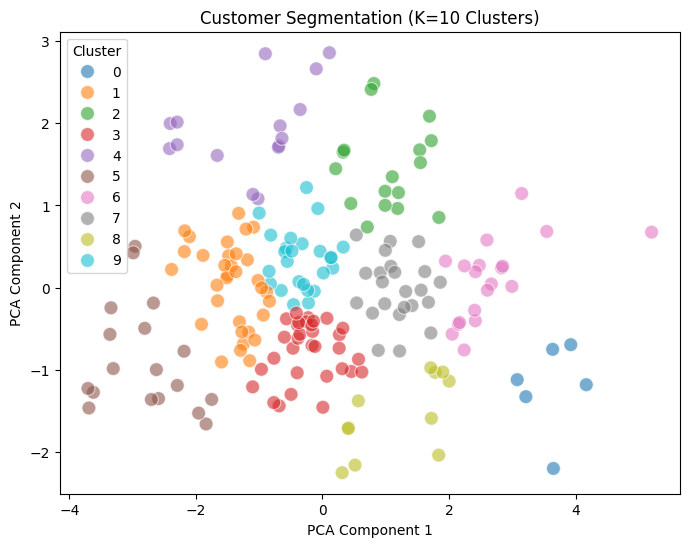

In [5]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Preprocessing

# Merge customer and transaction data
transactions_with_customers = pd.merge(transactions, customers, on='CustomerID', how='left')

# Aggregate transaction data by customer
customer_summary = transactions_with_customers.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    avg_spent_per_purchase=('TotalValue', 'mean'),
    num_purchases=('TransactionID', 'nunique'),
).reset_index()

# Merge with customer demographic data
customer_summary = pd.merge(customer_summary, customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# Select the features for clustering (we can include profile data and transaction data)
features = customer_summary[['total_spent', 'total_quantity', 'avg_spent_per_purchase', 'num_purchases']]

# Step 2: Feature Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Finding the optimal number of clusters using DB Index and Elbow Method

# List to store DB Index for different cluster sizes
db_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    db_index = davies_bouldin_score(features_scaled, kmeans.labels_)
    db_scores.append(db_index)

# Plot DB Index for different values of k to choose the optimal number of clusters
plt.plot(k_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Different K Values')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('DB Index')
plt.show()

# From the DB index plot, choose the k that gives the lowest DB index (good clustering)
optimal_k = k_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Step 4: Apply K-Means Clustering with the optimal number of clusters

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_summary['Cluster'] = kmeans.fit_predict(features_scaled)

# Step 5: Evaluate Clustering with Metrics
db_index = davies_bouldin_score(features_scaled, customer_summary['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Step 6: Visualize the clusters
# 2D visualization using PCA (Principal Component Analysis) for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=customer_summary['Cluster'], palette='tab10', s=100, alpha=0.6)
plt.title(f'Customer Segmentation (K={optimal_k} Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Step 7: Output the clustering results
# Saving the clustering results to a CSV file
customer_summary.to_csv('customer_segmentation_results.csv', index=False)
